### Overview

- This VaR model is fairly dynamic and allows for adaptability to different lookback periods, new portfolios, different stocks, and multiple VaR assumptions

- The model is robust as it only requires minor data cleaning and compatibility between the dictionary of holdings and the data frame of stock returns

In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.stats import chisquare, norm, shapiro

pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)  
pd.set_option('display.max_colwidth', None)

In [181]:
# Downloading Stock Data

tickers = ["RTX", "AMAT", "GOOGL", "FTNT"]
end_date = pd.Timestamp.now()
start_date = end_date - pd.DateOffset(years=2)
yf_px_df = yf.download(tickers=tickers, start=start_date, end=end_date, progress=False)
yf_px_df = yf_px_df['Close']
yf_px_df.head()

Ticker,AMAT,FTNT,GOOGL,RTX
Date,,,,
2023-02-27,110.184662,59.619999,89.545395,94.448196
2023-02-28,114.196030,59.439999,89.734703,93.429039
2023-03-01,115.287361,58.439999,90.033623,93.381424
2023-03-02,116.457344,59.639999,91.667702,94.295807
2023-03-03,116.958763,60.840000,93.311737,94.314842


In [182]:
# Creating a Dictionary of the Portfolio's Holdings

hlds_dict = {'AMAT': 75,
             'GOOGL': 100,
             'FTNT': 75,
             'RTX': 150}

In [183]:
# Creating a Comprehensive VaR Class

class ValueAtRisk:
    

    def __init__(self, px_hist, hlds, percentile, alpha, lookback, bins):
        self.px_hist = px_hist
        self.hlds = hlds
        self.percentile = percentile
        self.alpha = alpha
        self.lookback = lookback
        self.bins = bins


    # Portfolio's Daily Returns
    def portfolio_returns(self):

        relevant_px_hist = self.px_hist[self.hlds.keys()].copy()

        for col in relevant_px_hist.columns:
            if col in list(self.hlds.keys()):
                relevant_px_hist.loc[:, col] = self.hlds[col] * relevant_px_hist[col]
            else:
                continue

        relevant_px_hist['Portfolio Value'] = relevant_px_hist.sum(axis=1)
        relevant_px_hist['Portfolio Pct Chg'] = relevant_px_hist['Portfolio Value'].pct_change()

        return relevant_px_hist
    

    # Test for Normality
    def shapiro_wilks(self, relevant_px_hist):
        relevant_px_hist = relevant_px_hist.dropna()
        lookback_relevant_px_hist = relevant_px_hist.tail(self.lookback)
        pf_returns = lookback_relevant_px_hist['Portfolio Pct Chg']
        results = shapiro(pf_returns)
        
        return f"Test for normality p-value of {round(results.pvalue, 4)} for {self.lookback} day lookback"
    
    
    # Test for Goodness of Fit
    def chi_square_test(self, relevant_px_hist):
        relevant_px_hist = relevant_px_hist.dropna()
        lookback_relevant_px_hist = relevant_px_hist.tail(self.lookback)
        
        binned = pd.cut(lookback_relevant_px_hist['Portfolio Pct Chg'], bins=self.bins)
        observed_counts = binned.value_counts().sort_index()

        mu = lookback_relevant_px_hist['Portfolio Pct Chg'].mean()
        sigma = lookback_relevant_px_hist['Portfolio Pct Chg'].std()

        bin_edges = binned.cat.categories

        expected_counts = np.zeros(self.bins)
        
        for i, bin_edge in enumerate(bin_edges):
            lower_cdf = norm.cdf(bin_edge.left, mu, sigma)
            upper_cdf = norm.cdf(bin_edge.right, mu, sigma)
            
            bin_probability = upper_cdf - lower_cdf
            
            expected_counts[i] = bin_probability * len(lookback_relevant_px_hist)

        if np.sum(observed_counts) != np.sum(expected_counts):
            expected_counts = expected_counts * (np.sum(observed_counts) / np.sum(expected_counts))

        chi_square_stat, p_value = chisquare(observed_counts, expected_counts)

        return f"Goodness of fit p-value of {round(p_value, 4)} for {self.lookback} day lookback"


    # Histogram of the Portfolio's Returns
    def histogram(self, relevant_px_hist):

        relevant_px_hist = relevant_px_hist.dropna()
        lookback_relevant_px_hist = relevant_px_hist.dropna().tail(self.lookback)
        
        sns.set_style("whitegrid")
        plt.figure(figsize=(10, 6))
        sns.histplot(lookback_relevant_px_hist['Portfolio Pct Chg'], bins=self.bins, edgecolor='black')

        plt.title(f"Distribution of Portfolio Daily Returns | Lookback: {self.lookback}", fontsize=20, fontweight='bold', color='black')
        plt.ylabel("Frequency", fontsize=12, fontweight='bold')
        plt.xlabel("Portfolio Pct Chg", fontsize=12, fontweight='bold')
        plt.xticks(fontsize=10, fontweight='bold')
        plt.yticks(fontsize=10, fontweight='bold')

        sns.despine()
        plt.tight_layout()


    # Normal Portfolio VaR
    def parametric_normal(self, relevant_px_hist):
        lookback_relevant_px_hist = relevant_px_hist.dropna().tail(self.lookback)
        pf_value = relevant_px_hist['Portfolio Value'].iloc[-1]
        pf_returns = lookback_relevant_px_hist['Portfolio Pct Chg']
        
        mu = pf_returns.mean()
        sigma = pf_returns.std()
        z_score = norm.ppf(self.alpha)
        percent_VaR = mu + z_score * sigma

        return f"{round(pf_value*percent_VaR, 2)} VaR for {self.lookback} day lookback"

    
    # Percentile Portfolio VaR
    def historic_percentile(self, relevant_px_hist):

        lookback_relevant_px_hist = relevant_px_hist.dropna().tail(self.lookback)
        pf_value = relevant_px_hist['Portfolio Value'].iloc[-1] 
        percent_VaR = np.percentile(lookback_relevant_px_hist['Portfolio Pct Chg'], self.percentile)
        
        return f"{round(pf_value*percent_VaR, 2)} VaR for {self.lookback} day lookback"
    
    # Monte-Carlo Portfolio VaR
    def monte_carlo(self, relevant_px_hist, n=10000):
        lookback_relevant_px_hist = relevant_px_hist.dropna().tail(self.lookback)
        pf_returns = lookback_relevant_px_hist['Portfolio Pct Chg']
        pf_value = relevant_px_hist['Portfolio Value'].iloc[-1] 

        mu = pf_returns.mean()
        sigma = pf_returns.std()

        samples = np.random.normal(loc=mu, scale=sigma, size=n)
        percent_VaR = np.percentile(samples, self.percentile)

        return f"{round(pf_value*percent_VaR, 2)} VaR for {self.lookback} day lookback"

### Value at Risk for 250 Day Lookback Period

In [184]:
# Initializing the ValueAtRisk Class

VaR = ValueAtRisk(px_hist=yf_px_df, hlds=hlds_dict, percentile=5, alpha=0.05, lookback=250, bins=20)

VaR_portfolio_returns = VaR.portfolio_returns()
pd.DataFrame(VaR_portfolio_returns).tail()

Ticker,AMAT,GOOGL,FTNT,RTX,Portfolio Value,Portfolio Pct Chg
Date,,,,,,
2025-02-18,12870.355225,18377.000427,8569.500160,18470.519257,58287.375069,0.007981
2025-02-19,13024.500275,18527.000427,8592.749977,18716.773224,58861.023903,0.009842
2025-02-20,13200.749588,18455.999756,8565.749931,18671.999359,58894.498634,0.000569
2025-02-21,12898.499680,17966.000366,8251.499748,18493.500137,57609.499931,-0.021819
2025-02-24,12642.750549,17925.000000,8151.750183,18814.500046,57534.000778,-0.001311


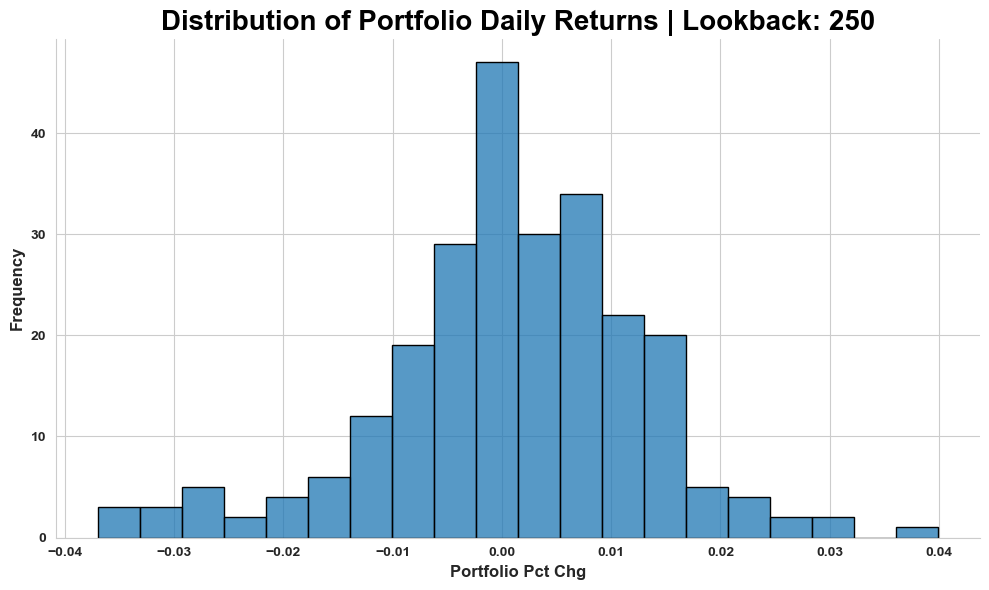

In [185]:
# Visualizing the Portfolio's Return Distribution

VaR.histogram(VaR_portfolio_returns)

In [186]:
# Calculating the Test for Normality

VaR.shapiro_wilks(VaR_portfolio_returns)

'Test for normality p-value of 0.0001 for 250 day lookback'

In [187]:
# Calculating the Chi-Square Test for Goodness of Fit

VaR.chi_square_test(VaR_portfolio_returns)

'Goodness of fit p-value of 0.0 for 250 day lookback'

In [188]:
# Calculating the Portfolio's VaR Using a Parametric Method

VaR.parametric_normal(VaR_portfolio_returns)

'-1080.11 VaR for 250 day lookback'

In [189]:
# Calculating the Portfolio's VaR Using a Historical Percentile Method

VaR.historic_percentile(VaR_portfolio_returns)

'-1214.66 VaR for 250 day lookback'

In [190]:
# Calculating the Portfolio's VaR Using a Monte Carlo Simulation

VaR.monte_carlo(VaR_portfolio_returns)

'-1092.99 VaR for 250 day lookback'

### Value at Risk for 180 Day Lookback Period

In [191]:
# Initializing the ValueAtRisk Class

VaR = ValueAtRisk(px_hist=yf_px_df, hlds=hlds_dict, percentile=5, alpha=0.05, lookback=180, bins=20)

VaR_portfolio_returns = VaR.portfolio_returns()
pd.DataFrame(VaR_portfolio_returns).head()

Ticker,AMAT,GOOGL,FTNT,RTX,Portfolio Value,Portfolio Pct Chg
Date,,,,,,
2023-02-27,8263.849640,8954.539490,4471.499920,14167.229462,35857.118511,NaN
2023-02-28,8564.702225,8973.470306,4457.999897,14014.355850,36010.528278,0.004278
2023-03-01,8646.552086,9003.362274,4382.999897,14007.213593,36040.127850,0.000822
2023-03-02,8734.300804,9166.770172,4472.999954,14144.371033,36518.441963,0.013272
2023-03-03,8771.907234,9331.173706,4563.000011,14147.226334,36813.307285,0.008074


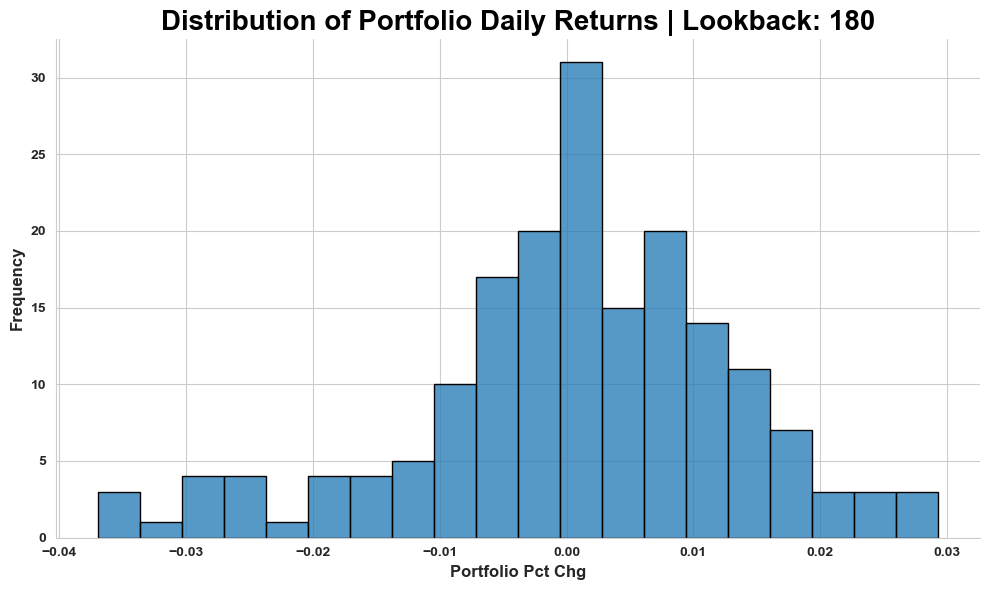

In [192]:
# Visualizing the Portfolio's Return Distribution

VaR.histogram(VaR_portfolio_returns)

In [193]:
# Calculating the Test for Normality

VaR.shapiro_wilks(VaR_portfolio_returns)

'Test for normality p-value of 0.0002 for 180 day lookback'

In [194]:
# Calculating the Chi-Square Test for Goodness of Fit

VaR.chi_square_test(VaR_portfolio_returns)

'Goodness of fit p-value of 0.0003 for 180 day lookback'

In [195]:
# Calculating the Portfolio's VaR Using a Parametric Method

VaR.parametric_normal(VaR_portfolio_returns)

'-1169.41 VaR for 180 day lookback'

In [196]:
# Calculating the Portfolio's VaR Using a Historical Percentile Method

VaR.historic_percentile(VaR_portfolio_returns)

'-1514.85 VaR for 180 day lookback'

In [197]:
# Calculating the Portfolio's VaR Using a Monte Carlo Simulation

VaR.monte_carlo(VaR_portfolio_returns)

'-1191.13 VaR for 180 day lookback'

### Value at Risk for 60 Day Lookback Period

In [198]:
# Initializing the ValueAtRisk Class

VaR = ValueAtRisk(px_hist=yf_px_df, hlds=hlds_dict, percentile=5, alpha=0.05, lookback=60, bins=20)

VaR_portfolio_returns = VaR.portfolio_returns()
pd.DataFrame(VaR_portfolio_returns).head()

Ticker,AMAT,GOOGL,FTNT,RTX,Portfolio Value,Portfolio Pct Chg
Date,,,,,,
2023-02-27,8263.849640,8954.539490,4471.499920,14167.229462,35857.118511,NaN
2023-02-28,8564.702225,8973.470306,4457.999897,14014.355850,36010.528278,0.004278
2023-03-01,8646.552086,9003.362274,4382.999897,14007.213593,36040.127850,0.000822
2023-03-02,8734.300804,9166.770172,4472.999954,14144.371033,36518.441963,0.013272
2023-03-03,8771.907234,9331.173706,4563.000011,14147.226334,36813.307285,0.008074


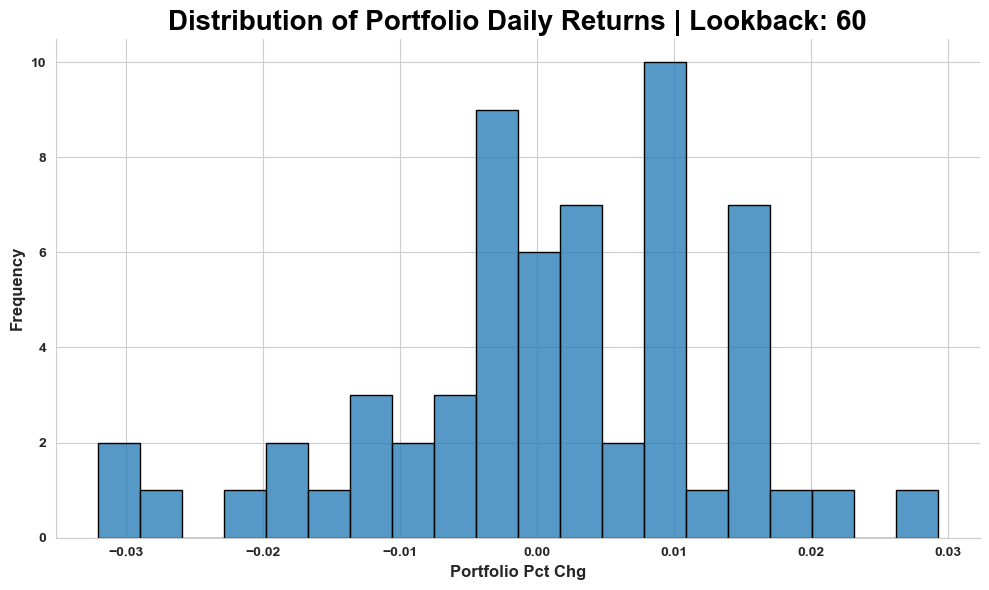

In [199]:
# Visualizing the Portfolio's Return Distribution

VaR.histogram(VaR_portfolio_returns)

In [200]:
# Calculating the Test for Normality

VaR.shapiro_wilks(VaR_portfolio_returns)

'Test for normality p-value of 0.2807 for 60 day lookback'

In [201]:
# Calculating the Chi-Square Test for Goodness of Fit

VaR.chi_square_test(VaR_portfolio_returns)

'Goodness of fit p-value of 0.0107 for 60 day lookback'

In [202]:
# Calculating the Portfolio's VaR Using a Parametric Method

VaR.parametric_normal(VaR_portfolio_returns)

'-1135.45 VaR for 60 day lookback'

In [203]:
# Calculating the Portfolio's VaR Using a Historical Percentile Method

VaR.historic_percentile(VaR_portfolio_returns)

'-1270.29 VaR for 60 day lookback'

In [204]:
# Calculating the Portfolio's VaR Using a Monte Carlo Simulation

VaR.monte_carlo(VaR_portfolio_returns)

'-1148.27 VaR for 60 day lookback'

### Graphing VaR for Each Lookback Period

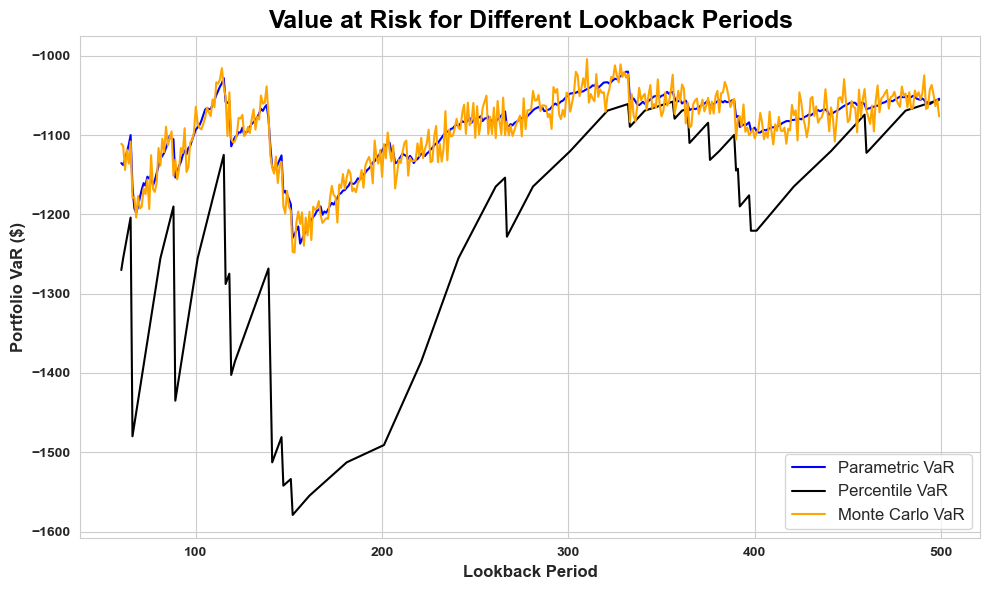

In [205]:
# Iterating Over a Lookback for Range to Calculate and Plot VaR

pf_VaR_para_ls = []
pf_VaR_hist_ls = []
pf_VaR_monte_ls = []
lookback_range = np.arange(60, len(yf_px_df))

for lookback in lookback_range:
    VaR = ValueAtRisk(px_hist=yf_px_df, hlds=hlds_dict, percentile=5, alpha=0.05, lookback=lookback, bins=20)
    
    VaR_portfolio_returns = VaR.portfolio_returns()
    
    pf_VaR_para = float(VaR.parametric_normal(VaR_portfolio_returns).split()[0])
    pf_VaR_para_ls.append(pf_VaR_para)

    pf_VaR_hist = float(VaR.historic_percentile(VaR_portfolio_returns).split()[0])
    pf_VaR_hist_ls.append(pf_VaR_hist)

    pf_VaR_monte = float(VaR.monte_carlo(VaR_portfolio_returns).split()[0])
    pf_VaR_monte_ls.append(pf_VaR_monte)


plt.figure(figsize=(10, 6))

plt.plot(lookback_range, pf_VaR_para_ls, label='Parametric VaR', color='blue', linestyle='-')
plt.plot(lookback_range, pf_VaR_hist_ls, label='Percentile VaR', color='black', linestyle='-')
plt.plot(lookback_range, pf_VaR_monte_ls, label='Monte Carlo VaR', color='orange', linestyle='-')

plt.legend(fontsize=12)

plt.title(f"Value at Risk for Different Lookback Periods", fontsize=18, fontweight='bold', color='black')
plt.xlabel("Lookback Period", fontsize=12, fontweight='bold')
plt.ylabel("Portfolio VaR ($)", fontsize=12, fontweight='bold')
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()